In [1]:
import pandas as pd

# Import events and time till each event
cohort = pd.read_excel("kihd_time_to_event.xlsx")
# Add a column with time in years (it will be used for plots)
cohort['time, years'] = (cohort['time']/365.25).astype(int)

In [5]:
# ---------------------------------------------------------
# Splitting into training and test parts with stratification
# ---------------------------------------------------------
def train_test_split(outcomes, train_percent = 0.8, event = 'event', time = 'time'):
    '''
    Split time-to-event data into training and test parts with stratification
    
    Parameters
    ----------
     outcomes: pd.DataFrame
         time-to-event data with columns that contain events and times 
     train_percent: float, optional
         percentage of training examples in splitting
     event: string, optional
         a string to define the column with events in the data frame
     time: string, optional
         a string to define the column with time in the data frame
         
    Returns
    -------
    training_indices: list
        a list with indices of training examples
    test_indices: list
        a list with indices of test examples
    '''
    
    if event not in outcomes.columns or time not in outcomes.columns:
        raise ValueError("'event' and/or 'time' columns are not found. Specify names of these columns in the function arguments")

    outcomes = outcomes.loc[:, [event, time]].copy()
    outcomes = outcomes.rename(columns={event: 'event', time: 'time'})
    
    outcomes.time = outcomes.time.astype(str)
    outcomes.event = outcomes.event.astype(str)
    
    training_indices = []
    test_indices = []

    for time in outcomes.time.unique():
        for event in outcomes.event.unique():
            subsample = outcomes.loc[ (outcomes.time == time) & (outcomes.event == event) ]

            if subsample.shape[0] > 0:
                train_index = list(subsample.sample(frac = train_percent, replace = False).index)
                train_index.sort()
                test_index = list(set(subsample.index) - set(train_index))

                training_indices.extend(train_index)
                test_indices.extend(test_index)

    training_indices.sort()
    test_indices.sort()
    
    return training_indices, test_indices

# An example of using the 'train_test_split' function with a default 0.8 sptitting ratio 
# training_indices, test_indices = train_test_split(cohort, time = 'time, years')

In [2]:
# Import and prepare data:
# -------------------------------------------------------
# 1 - A sample with seven traditional risk factors
# -------------------------------------------------------
kihd_preselected_predictors = pd.read_excel("kihd_7_inputs_na.xlsx")

# -------------------------------------------------------
# 2 - A sample with hundreds of predictors
# -------------------------------------------------------
kihd_predictors = pd.read_excel("KIHD_phenotypes.xlsx")

# Preprocessing of the second sample with many predictors
# Remove variables (columns) containing more than 5% of missing values
gaps = 0.05
threshold_columns = kihd_predictors.shape[0]-round(gaps*kihd_predictors.shape[0])
kihd_predictors = kihd_predictors.dropna(axis=1, thresh=threshold_columns)

# Turn the categorical variables into dummies
categorical_variables=['au0136','au0153','ek0115','ek0119','ka0118','mi0205','mi0207','mi0208','mi0209',
                       'mi0210','mi0211','mi0212','mi0213','mi0214','v0145','v0146','v0157','v0158','v0161',
                       'v0172','v0247','v0248','v0665','v0721','v0724','u1307']

for col in categorical_variables:
    if col in kihd_predictors.columns:
        new_dummies=pd.get_dummies(kihd_predictors[col], dummy_na=False)
        my_list = new_dummies.columns.values
        string = col+"_"
        my_new_list = [string + str(x) for x in my_list]
        new_dummies.columns = my_new_list
        kihd_predictors = kihd_predictors.drop(col, axis=1)       
        kihd_predictors = kihd_predictors.join(new_dummies)

print("Filter out predictors with more than {}% of missing values ...".format(gaps*100))
print("Dataset size: {rows}x{cols}".format(rows = kihd_predictors.shape[0], cols = kihd_predictors.shape[1]))
print("-------------------------------------")

Filter out predictors with more than 5.0% of missing values ...
Dataset size: 2682x658
-------------------------------------


____________________________________________
For the sample with pre-selected predictors:
____________________________________________

In [ ]:
import miceforest as mf
import numpy as np

# -------------------------------------------------------------------------------
# Function:
# Train an imputer with the MICE algorithm to fill gaps in training and test data
# -------------------------------------------------------------------------------

def filling_gaps_small_data(train_data, test_data):
    '''
    Fill gaps in training and test data using MICE
    
    Parameters
    ----------
    train_data: pd.DataFrame
         predictors with gaps to train an imputer 
    test_data: pd.DataFrame
         predictors with gaps to apply an imputer 
         
    Returns
    -------
    train_data_filled: pd.DataFrame
        training data with filled gaps
    test_data_filled: pd.DataFrame
        test data with filled gaps
    '''

    # Create kernel 
    np.random.seed()

    # Define parameters of the MICE algorithm from the miceforest package
    mice_kernel = mf.KernelDataSet(
    train_data,
    mean_match_candidates=5,
    save_all_iterations=True,
    save_models = 1,
    random_state=None
    )

    # Run 10 iterations of the MICE algorithm
    mice_kernel.mice(10, n_jobs=2, max_depth = 3, n_estimators=100, oob_score=True, bootstrap=True)

    # Return a training dataset filled
    train_filled = mice_kernel.complete_data()
    # Apply the trained imputer to a test dataset
    test_filled = mice_kernel.impute_new_data(new_data=test_data)
    # Return a test dataset filled
    test_filled = test_filled.complete_data()
    
    return train_filled, test_filled

In [38]:
# -------------------------------------------------------------------------------
# Splitting into training, test, training_valid and validation parts; 
# Filling gaps in each split
# -------------------------------------------------------------------------------

import os

N_runs = 1

# A directory to be created for the first (selected predictors) sample
folder1 = "splitting_7_predictors"

try:
    os.mkdir(folder1)
except OSError:
    print ("Creation of the directory %s failed (already exists?)" % folder1)
else:
    print ("Successfully created the directory %s" % folder1)

# Split data and save in files
for r in range(N_runs):
    # Split into training and test parts
    training_indices, test_indices = train_test_split(cohort, time = 'time, years')
    
    # Fill gaps in training and test data
    kihd_preselected_predictors_training, kihd_preselected_predictors_test = filling_gaps_small_data(
                                                                                kihd_preselected_predictors.loc[training_indices],
                                                                                kihd_preselected_predictors.loc[test_indices]
                                                                                                    )
    # For validation: Split into training and validation parts
    training_indices_on_validation, validation_indices = train_test_split(
                                                                    cohort.loc[training_indices],
                                                                    time = 'time, years'
                                                                         )
    
    # Save training, test, training_valid and validation parts for the selected predictors
    kihd_preselected_predictors_training.to_excel(folder1 + "/training_{}.xlsx".format(r))
    kihd_preselected_predictors_test.to_excel(folder1 + "/test_{}.xlsx".format(r))
    kihd_preselected_predictors_training.loc[training_indices_on_validation].to_excel(folder1 + "/training_valid_{}.xlsx".format(r))
    kihd_preselected_predictors_training.loc[validation_indices].to_excel(folder1 + "/validation_{}.xlsx".format(r))
    

Successfully created the directory splitting_7_predictors


____________________________________________
For the sample with many predictors:
____________________________________________

In [8]:
import miceforest as mf
import numpy as np

# -------------------------------------------------------------------------------
# Function:
# Train an imputer with the MICE algorithm to fill gaps in training and test data
# -------------------------------------------------------------------------------

def filling_gaps_big_data(train_data, test_data):
    '''
    Fill gaps in training and test data using MICE
    
    Parameters
    ----------
    train_data: pd.DataFrame
         predictors with gaps to train an imputer 
    test_data: pd.DataFrame
         predictors with gaps to apply an imputer 
         
    Returns
    -------
    train_filled: pd.DataFrame
        training data with filled gaps
    test_filled: pd.DataFrame
        test data with filled gaps
    '''

    # In this function, an imputer first is trained to fill gaps in the training data.
    # Then, training samples without gaps are combined with test sampes with gaps
    # and an inputer is trained again to fill gaps in the test data.
    # This is done in this way because test examples have missing values in variables 
    # that have no gaps in the training data, therefore, the MICE imputer cannot fill
    # them after training on the training data. 
    # This procedure immitates the real world scenario, when the model is first trained
    # on some data, then other unseen data come for tests. 
    
    # Create kernel 
    np.random.seed()

    # Define parameters of the MICE algorithm from the miceforest package
    mice_kernel = mf.KernelDataSet(
    train_data,
    mean_match_candidates=5,
    save_all_iterations=True,
    save_models = 1,
    random_state=None
    )

    # Run 10 iterations of the MICE algorithm
    mice_kernel.mice(10, n_jobs=10, max_depth = 5, n_estimators=100, oob_score=True, bootstrap=True)

    # Return a training dataset filled
    train_filled = mice_kernel.complete_data()

    # Train and test joint sample
    test_starts = train_filled.shape[0]
    all_samples = pd.concat([train_filled, test_data])
    
    # Create kernel for all samples
    np.random.seed()

    mice_kernel_test = mf.KernelDataSet(
    all_samples,
    mean_match_candidates=5,
    save_all_iterations=False,
    save_models = 1,
    random_state=None
    )
    
    # Run the MICE algorithm for 10 iterations (to fill gaps in test samples)
    mice_kernel_test.mice(10, n_jobs=10, max_depth = 5, n_estimators=100, oob_score=True, bootstrap=True)
    
    # Fill gaps in samples (gaps are in test samples)
    all_samples_filled = mice_kernel_test.complete_data()

    # Return filled test samples
    test_filled = all_samples_filled.iloc[test_starts:,]
    
    
    return train_filled, test_filled

In [9]:
# -------------------------------------------------------------------------------
# Splitting into training, test, training_valid and validation parts; 
# Filling gaps in each split
# -------------------------------------------------------------------------------

import os

N_runs = 10

# A directory to be created for the first (selected predictors) sample
folder2 = "splitting_{}_predictors".format(kihd_predictors.shape[1])

try:
    os.mkdir(folder2)
except OSError:
    print ("Creation of the directory %s failed (already exists?)" % folder2)
else:
    print ("Successfully created the directory %s" % folder2)

# Split data and save in files
for r in range(N_runs):
    # Split into training and test parts
    training_indices, test_indices = train_test_split(cohort, time = 'time, years')
    
    # Fill gaps in training and test data
    kihd_training, kihd_test = filling_gaps_big_data(
                                                    kihd_predictors.loc[training_indices],
                                                    kihd_predictors.loc[test_indices]
                                                    )
    # For validation: Split into training and validation parts
    training_indices_on_validation, validation_indices = train_test_split(
                                                                    cohort.loc[training_indices],
                                                                    time = 'time, years'
                                                                         )
    
    # Save training, test, training_valid and validation parts for the selected predictors
    kihd_training.to_excel(folder2 + "/training_{}.xlsx".format(r))
    kihd_test.to_excel(folder2 + "/test_{}.xlsx".format(r))
    kihd_training.loc[training_indices_on_validation].to_excel(folder2 + "/training_valid_{}.xlsx".format(r))
    kihd_training.loc[validation_indices].to_excel(folder2 + "/validation_{}.xlsx".format(r))
    

Creation of the directory splitting_658_predictors failed (already exists?)


_____________________________________________________________
Check (visually) CIFs of all subjects, training and test data
_____________________________________________________________

In [20]:
# Load the rpy2 IPython extension into the notebook to use R with a magic command: %%R
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [21]:
%%R
# :::::::::
# R kernel
# :::::::::

install.packages("readxl")
install.packages("cmprsk")

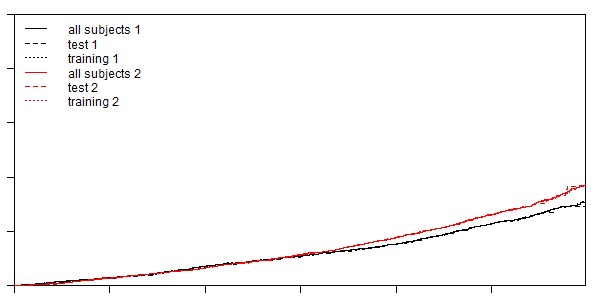

In [22]:
%%R -w 600 -h 300
# ----------------------------------------------------------------
# Cumulative Incidence Functions (CIFs) for training and test data
# ----------------------------------------------------------------

# Load necessary packages
library("readxl")

# Import the CumIncidence function from the file 
source("CumIncidence.R")

par(mar=c(1,1,1,1))

path_to_training <- "splitting_7_predictors/training_1.xlsx" # Choose splitting to check
path_to_test <- "splitting_7_predictors/test_1.xlsx" # Choose splitting to check

cohort_test <- read_excel(path_to_test)

cohort <- read_excel("kihd_time_to_event.xlsx")
cohort["sample"] <- "training"
cohort[unlist(cohort_test[,1])+1, "sample"] <- "test"

# Add examples without splitting
cohort_all <- cohort
cohort_all['sample'] <- 'all subjects'
cohort_all <- rbind(cohort_all, cohort)

# !!! To save a plot in a file, uncomment the next line: 
# png("CIFs train test.png", res = 200, width = 1500, height = 800,  units = 'px')

# Compare CIFs in training and test parts to the whole cohort
# Main parameters are times, events, groups (training/test/no splitting), code for censoring
fit = CumIncidence(cohort_all$time, cohort_all$event, cohort_all$sample, cencode = 0, xlab = 'time', ylab = 'CIF')
